In [302]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [303]:
df_final = pd.read_csv("processed_moroccan_exports_fish.csv")

In [304]:
df_final.set_index('Year', inplace=True) # Définir les années comme index

In [305]:
df_final.head()

,Product label,Exported Value
Year,,
2003,"Fish and crustaceans, molluscs and other aquat...",0.125295
2004,"Fish and crustaceans, molluscs and other aquat...",0.000000
2005,"Fish and crustaceans, molluscs and other aquat...",0.137429
2006,"Fish and crustaceans, molluscs and other aquat...",0.197313
2007,"Fish and crustaceans, molluscs and other aquat...",0.324361


In [306]:
df_final.index

Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int64', name='Year')

In [307]:
# Diviser les données en 'train' et 'test' parties, en prenant comme année de séparation 2018.
train_df = df_final[df_final.index <= 2020]
test_df = df_final[df_final.index >= 2020]

In [308]:
print(train_df)

                                          Product label  Exported Value
Year                                                                   
2003  Fish and crustaceans, molluscs and other aquat...        0.125295
2004  Fish and crustaceans, molluscs and other aquat...        0.000000
2005  Fish and crustaceans, molluscs and other aquat...        0.137429
2006  Fish and crustaceans, molluscs and other aquat...        0.197313
2007  Fish and crustaceans, molluscs and other aquat...        0.324361
2008  Fish and crustaceans, molluscs and other aquat...        0.408324
2009  Fish and crustaceans, molluscs and other aquat...        0.267850
2010  Fish and crustaceans, molluscs and other aquat...        0.241294
2011  Fish and crustaceans, molluscs and other aquat...        0.337029
2012  Fish and crustaceans, molluscs and other aquat...        0.347930
2013  Fish and crustaceans, molluscs and other aquat...        0.402130
2014  Fish and crustaceans, molluscs and other aquat...        0

In [309]:
print(test_df)

                                          Product label  Exported Value
Year                                                                   
2020  Fish and crustaceans, molluscs and other aquat...        0.610974
2021  Fish and crustaceans, molluscs and other aquat...        1.000000
2022  Fish and crustaceans, molluscs and other aquat...        0.871932


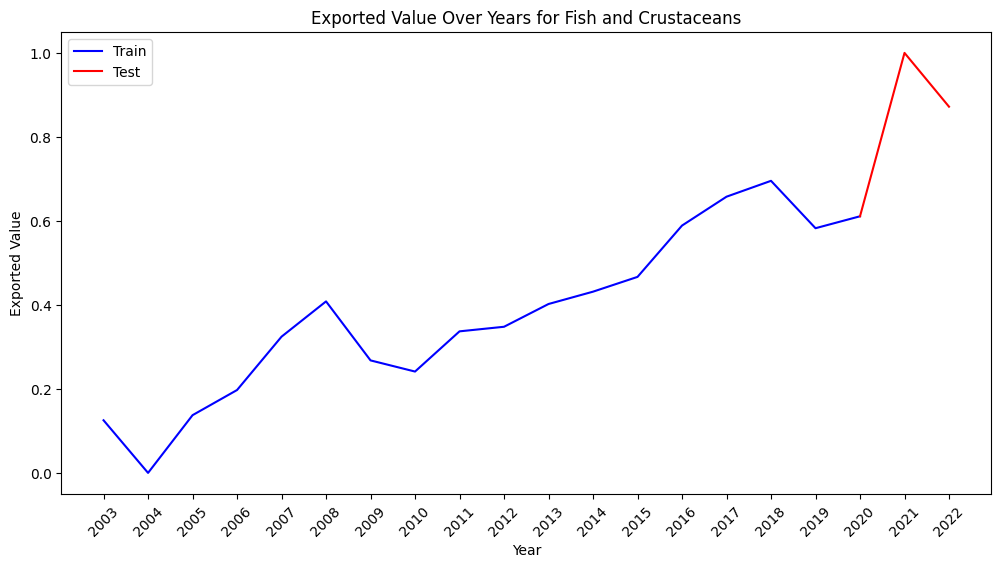

In [310]:
# Plot the data

plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Exported Value'], 'b', label='Train') # Bleu
plt.plot(test_df.index, test_df['Exported Value'], 'r', label='Test') # Rouge
plt.xlabel('Year')
plt.ylabel('Exported Value')
plt.title('Exported Value Over Years for Fish and Crustaceans')
plt.xticks(df_final.index, rotation=45)
plt.legend()
plt.show()

In [311]:
# Faire le test KPSS pour avoir une information sur la stationnarité des données
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df_final['Exported Value'], regression='c', nlags="auto")
print('\nKPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'{key}: {value}')


KPSS Statistic: 0.7363599311293135
p-value: 0.010240006260971497
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


In [312]:
# Un autre test : ADF
alpha = 0.05  # 5% est le seuil de significativité

if kpss_result[1] <= alpha:
    print("Reject the null hypothesis (H0) of the KPSS test. Thus, the data is not stationary.")
else:
    print("Fail to reject the null hypothesis (H0) of the KPSS test. Thus, the data is stationary.")

Reject the null hypothesis (H0) of the KPSS test. Thus, the data is not stationary.


In [313]:
# We have to go for ARIMA model as it will fit more for non-stationary data !!

In [ ]:
pip install pmdarima # Il est nécessaire d'installer pmdarima en premier lieu !!

In [ ]:
from pmdarima import auto_arima # auto_arima va nous informer sur les meilleures paramètres à choisir pour la prédiction...

# Utiliser auto_arima pour trouver le meilleur modèle ARIMA avec une recherche exhaustive
stepwise_fit = auto_arima(df_final['Exported Value'],
                          start_p=0, max_p=10,  # Augmenter la plage de recherche pour p
                          start_q=0, max_q=10,  # Augmenter la plage de recherche pour q
                          start_d=0, max_d=10,
                          d=None,  # auto_arima déterminera la meilleure valeur pour d
                          seasonal=False,  # Ne pas inclure de composante saisonnière
                          stepwise=False,  # Utiliser une recherche exhaustive
                          trace=True,  # Afficher les résultats de chaque étape
                          suppress_warnings=True,  # Supprimer les avertissements
                          information_criterion='bic')  # Utiliser AIC pour la sélection du modèle

In [ ]:
# Afficher le résumé du modèle auto_arima
print(stepwise_fit.summary())

In [ ]:
# Train the ARIMA model using the best parameters found by auto_arima
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_df['Exported Value'], order=(6,1,2)) # (0, 1, O) est l'ordre qu'a proposé auto_arima, mais ca ne fait pas mieux que l'ordre (6, 1, 2).
# Cela peut etre expliqué par le fait que auto-arima ne teste pas vraiment toutes les combinaisons possibles.
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
# Make forecasting for the test set
predictions = model_fit.forecast(steps=len(test_df))

In [ ]:
# Plot the original data, training data, test data, and the predictions
plt.figure(figsize=(12, 6))
plt.plot(df_final.index, df_final['Exported Value'], label='Original Data')
plt.plot(train_df.index, train_df['Exported Value'], label='Train Data', color='blue')
plt.plot(test_df.index, test_df['Exported Value'], label='Test Data', color='red')
plt.plot(test_df.index, predictions, label='Predictions', color='green')
plt.xlabel('Year')
plt.ylabel('Exported Value')
plt.title('Exported Value Over Years for Fish and Crustaceans with Test Predictions')
plt.xticks(range(2003, 2023), rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the RMSE (Root Mean Square Error)
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test_df['Exported Value'], predictions))
print(f'Root Mean Squared Error: {rmse}')

In [ ]:
# Forecast future values up to 2030 (Prédire les valeurs d'ici 2030)
forecast_steps = 2030 - 2022
arima_full_forecast = model_fit.get_forecast(steps=forecast_steps)
future_pred = arima_full_forecast.predicted_mean
future_conf_int = arima_full_forecast.conf_int()

future_index = pd.RangeIndex(start=2022, stop=2022 + forecast_steps, step=1)

plt.figure(figsize=(12, 6))
plt.plot(df_final.index, df_final['Exported Value'], label='Historical Exported Value')
plt.plot(future_index, future_pred, label='Forecasted Exported Value', color='blue')
plt.fill_between(future_index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Exported Value (Standardized)')
plt.title('Forecasted Exported Value (2023-2030)')
plt.legend()
plt.show()

In [ ]:
# Obtenir le maximum des valeurs prédites
future_max_pred = future_conf_int.max(axis=1)

future_index = pd.RangeIndex(start=2022, stop=2022 + forecast_steps, step=1)

plt.figure(figsize=(12, 6))
plt.plot(df_final.index, df_final['Exported Value'], label='Historical Exported Value')
plt.plot(future_index, future_max_pred, label='Forecasted Exported Value', color='blue')
plt.fill_between(future_index, future_conf_int.iloc[:, 0], future_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Exported Value (Standardized)')
plt.title('Forecasted Exported Value (2023-2030)')
plt.legend()
plt.show()

In [ ]:
# On peut voir clairement que les valeurs des exportations de produits halieutiques tendent à augmenter au fil du temps
# Alors, il serait judicieux de discuter des stratégies pour maintenir cette croissance et en bénéficier.